## TODO:
+ Add transform to vid image? Yes, need to resize to 256
+ Standardize number of frame. OR find a way to group dataset by similar frames.


In [1]:
!pip install torch-summary
 
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from glob import glob
from tqdm import tqdm
from PIL import Image

import torchvision
from torchvision import models
from torchsummary import summary
import time

import os
import pandas as pd
import math
# from AUTSLDataset import AUTSLDataset 


  Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)


## Dataset Class


In [2]:
class AUTSLDataset(Dataset):
    '''
    Dataset for the AUTSL data
    '''
    
    
    def __init__(self, data_type, max_frame_no, frame_interval = 1, data_path ="./dataset/" ):
        self.data_type = data_type
        self.frame_interval = frame_interval
        self.data_path = {"train": data_path + "train/",
                          "val": data_path + "val/"
                         }        
        self.data_length = {"train":  len(glob(f"{self.data_path['train']}*_color.mp4")),
                            "val": len(glob(f"{self.data_path['val']}*_color.mp4"))
                           }
        # self.data_length = {"train":  len(os.listdir(self.data_path["train"]))}
        self.label_path = {"train": data_path + "train_labels.csv",
                           "val": data_path + "val_labels.csv"
                          }
        self.labels = pd.read_csv(self.label_path[self.data_type],names = ["file_name", "label"])
#         self.max = 156
        self.file_ls = glob(f"{self.data_path[self.data_type]}*_color.mp4")
        self.max_frame_no = max_frame_no
        self.device = "cuda"

#         self.max = self.get_max()
        
    def Describe(self):
        msg = "AUTSL Dataset\n"
        print(msg)
        
    def GetLabel(self, file_name):
        return self.labels[self.labels.file_name ==file_name]["label"].values[0]
    
    def GetVideoArray(self, file_name):

        cap = cv2.VideoCapture(self.data_path[self.data_type] + file_name)   # capturing the video from the given path
        video_arr = []
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % self.frame_interval == 0):
                # Converting to tensor
                frame =  torchvision.transforms.functional.to_tensor(frame).float().to(self.device)
                frame = frame.unsqueeze(0)
                frame =  F.interpolate(frame, (256,256), mode='bilinear')
                frame = frame.squeeze(0)
                video_arr.append(frame)
        cap.release()

    
        if len(video_arr)<self.max_frame_no:
            empty_frame = torch.zeros((3,256,256)).to(self.device)
            padding  = [empty_frame]*(self.max_frame_no-len(video_arr))
            video_arr+=padding

        return torch.stack(video_arr) 
        
    def __len__(self):
        return self.data_length[self.data_type]
    
    def __getitem__(self, index):
        '''
        Return 4D array consists of all the frame of the video image AND the label
        '''
        file_name = os.path.basename(self.file_ls[index])
        video_arr = self.GetVideoArray(file_name)
        
        label = self.GetLabel(file_name[:-10]) #slice to get just the name without file ext and file type
        return video_arr, label
        
    def get_max(self):
        max_length = 0
        for i in tqdm(range(len(self))):
            video, label = self[i]
            if video.shape[0]>max_length:
                max_length = video.shape[0]
        return max_length
    


In [3]:
class AUTSLDatasetROI(Dataset):
    '''
    Dataset for the AUTSL data
    '''
    
    
    def __init__(self, data_type, max_frame_no, frame_interval = 1, data_path ="./dataset/" ):
        self.data_type = data_type
        self.frame_interval = frame_interval
        self.data_path = {"train": data_path + "train/",
                          "val": data_path + "val/"
                         }        
        self.data_length = {"train":  len(glob(f"{self.data_path['train']}*_color.mp4")),
                            "val": len(glob(f"{self.data_path['val']}*_color.mp4"))
                           }
        # self.data_length = {"train":  len(os.listdir(self.data_path["train"]))}
        self.label_path = {"train": data_path + "train_labels.csv",
                           "val": data_path + "val_labels.csv"
                          }
        self.labels = pd.read_csv(self.label_path[self.data_type],names = ["file_name", "label"])
#         self.max = 156
        self.file_ls = glob(f"{self.data_path[self.data_type]}*_color.mp4")
        self.max_frame_no = max_frame_no
        self.device = "cuda"

#         self.max = self.get_max()
        
    def Describe(self):
        msg = "AUTSL Dataset\n"
        print(msg)
        
    def GetLabel(self, file_name):
    
        return self.labels[self.labels.file_name ==file_name]["label"].values[0]
    
    def GetVideoArray(self, file_name):

        cap = cv2.VideoCapture(self.data_path[self.data_type] + file_name)   # capturing the video from the given path
        video_arr = []
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % self.frame_interval == 0):
                # Converting to tensor
                frame =  torchvision.transforms.functional.to_tensor(frame).float().to(self.device)
                frame = frame.unsqueeze(0)
                frame =  F.interpolate(frame, (128,128), mode='bilinear')
                frame = frame.squeeze(0)
                video_arr.append(frame)
        cap.release()

    
        if len(video_arr)<self.max_frame_no:
            empty_frame = torch.zeros((3,128,128)).to(self.device)
            padding  = [empty_frame]*(self.max_frame_no-len(video_arr))
            video_arr+=padding

        return torch.stack(video_arr) 
        
    def __len__(self):
        return self.data_length[self.data_type]
    
    def __getitem__(self, index):
        '''
        Return 4D array consists of all the frame of the video image AND the label
        '''
        file_name = os.path.basename(self.file_ls[index])
        d_file_name = file_name.replace("color","roi")
        
        video_arr = self.GetVideoArray(file_name)
        label = self.GetLabel(file_name[:-10]) #slice to get just the name without file ext and file type
        videoroi_arr = self.GetVideoArray(file_name.replace("color","roi"))
        file_name.replace("roi","color")
        return video_arr, videoroi_arr, label
        
    def get_max(self):
        max_length = 0
        for i in tqdm(range(len(self))):
            video, label = self[i]
            if video.shape[0]>max_length:
                max_length = video.shape[0]
        return max_length
    


In [4]:
!ls ..

Sign-Language-Recognition-using-Deep-Learning  train_labels.csv  val_labels.csv
train					       val


In [4]:
torch.manual_seed(0)

batch_size = 2

# train_autsl = AUTSLDataset("train", int(156/2), frame_interval=2, data_path="../")
# val_autsl = AUTSLDataset("val", int(114/2), frame_interval=2, data_path="../")
trainROI_autsl = AUTSLDatasetROI("train", int(156/2), frame_interval=4, data_path="../")
valROI_autsl = AUTSLDatasetROI("val", int(114/2), frame_interval=4, data_path="../")
# trainloader = DataLoader(train_autsl, batch_size=batch_size, shuffle=True)
# valloader = DataLoader(val_autsl, batch_size=batch_size, shuffle=True)
trainroiloader = DataLoader(trainROI_autsl, batch_size=batch_size, shuffle=True)
valroiloader = DataLoader(valROI_autsl, batch_size=batch_size, shuffle=True)


# print(f"Length of train dataset: {len(train_autsl)}")
# print(f"Length of val dataset: {len(val_autsl)}")
# start = time.process_time()
# video, label = train_autsl[1]
# print(f"Time taken to load 1 datapoint = {time.process_time() - start}")
# print(f"Sample training data:\ninput shape: {video.shape}\noutput: {label}")
# plt.imshow(video[0].cpu().permute(1,2,0))



### Exploration of Valve Filter Method in addition to Baseline Model
In this notebook, we will be exploring modifying the baseline model specifically the VGG model to include ROI information. In this way of exploration, the aim is to modify the VGG model to direct attention  to a given ROI region without loss of background information. To do this, a valve filter approach will be used. 
<br>
<br>
For each filter on the image, there will be a correspoding valve filter on the ROI map. This generates the features map and relevance map respectively. 
The features maps and relavance maps are multiplied element-wise with output of the image filter convolution to give a normalized feature map. This map is used as input for the next layers. 
<br>
<br>
Valve filters can be seen as a valve that regularizes the activation of image filters in different regions of the image. 
<br>
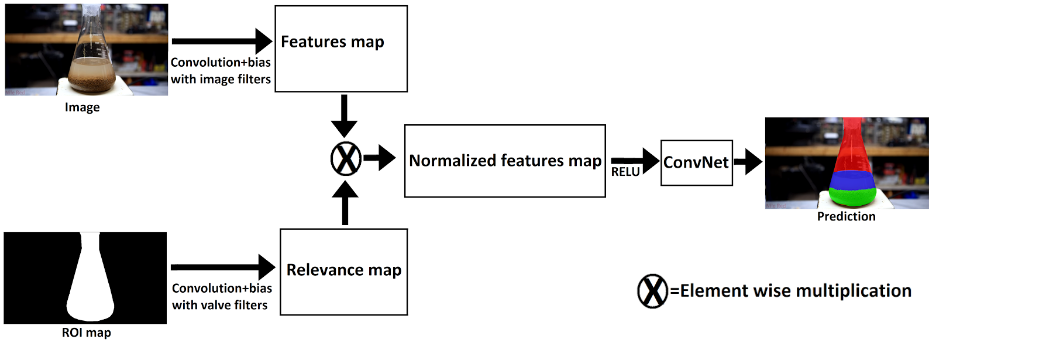
<br>

### Pre-processing
The dataset provided consists of the depth and rgb videos. Both types of videos will be used in this case. The rgb video will be used as the main image, the depth video will be used to generate an ROI binary image (white for ROI, black for background). 
<br>
To convert the depth video to ROI video, threshold and dilation algorithms are used. For the threshold algorithm, pixels that are greater than 20 in value are regarded as ROI. Dilation of 1 iteration is done to close up any gaps within the ROI. 


In [6]:
TRAIN_PATH = "../train/"
VAL_PATH = "../val/"
files_train = os.listdir(TRAIN_PATH)
filtered_train = [file for file in files_train if "depth" in file]
files_val = os.listdir(VAL_PATH)
filtered_val = [file for file in files_val if "depth" in file]

In [7]:
# Pre-processing to generate ROI Images
target1 = "signer0_sample1_depth.mp4"
def generate_roi(filter_path, filtered):
    for filename in tqdm(filtered):
        name = filter_path + filename 
    #     name = target1
        cap = cv2.VideoCapture(name)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 960)

        filename = name.replace("depth","roi")
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#         print(filename)
        out = cv2.VideoWriter(filename, fourcc, 30, (512, 512))

        while True:
            _, frame = cap.read()
            if frame is None:
                break
            output = frame.copy()
            retval,thresh = cv2.threshold(frame, 20, 255, cv2.THRESH_BINARY)
            kernel = np.ones((5,5),np.uint8)
            dilation = cv2.dilate(thresh,kernel,iterations = 1)
            out.write(dilation)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break

        out.release()

# generate_roi(TRAIN_PATH, filtered_train)
# generate_roi(VAL_PATH, filtered_val)

In [8]:
!ls ../val

signer11_sample100_color.mp4  signer1_sample188_color.mp4
signer11_sample100_depth.mp4  signer1_sample188_depth.mp4
signer11_sample100_roi.mp4    signer1_sample188_roi.mp4
signer11_sample101_color.mp4  signer1_sample189_color.mp4
signer11_sample101_depth.mp4  signer1_sample189_depth.mp4
signer11_sample101_roi.mp4    signer1_sample189_roi.mp4
signer11_sample102_color.mp4  signer1_sample18_color.mp4
signer11_sample102_depth.mp4  signer1_sample18_depth.mp4
signer11_sample102_roi.mp4    signer1_sample18_roi.mp4
signer11_sample103_color.mp4  signer1_sample190_color.mp4
signer11_sample103_depth.mp4  signer1_sample190_depth.mp4
signer11_sample103_roi.mp4    signer1_sample190_roi.mp4
signer11_sample104_color.mp4  signer1_sample191_color.mp4
signer11_sample104_depth.mp4  signer1_sample191_depth.mp4
signer11_sample104_roi.mp4    signer1_sample191_roi.mp4
signer11_sample105_color.mp4  signer1_sample192_color.mp4
signer11_sample105_depth.mp4  signer1_sample192_depth.mp4
signer11_sample105_roi.mp4 

signer1_sample1339_depth.mp4  signer35_sample630_depth.mp4
signer1_sample1339_roi.mp4    signer35_sample630_roi.mp4
signer1_sample133_color.mp4   signer35_sample631_color.mp4
signer1_sample133_depth.mp4   signer35_sample631_depth.mp4
signer1_sample133_roi.mp4     signer35_sample631_roi.mp4
signer1_sample1340_color.mp4  signer35_sample632_color.mp4
signer1_sample1340_depth.mp4  signer35_sample632_depth.mp4
signer1_sample1340_roi.mp4    signer35_sample632_roi.mp4
signer1_sample1341_color.mp4  signer35_sample633_color.mp4
signer1_sample1341_depth.mp4  signer35_sample633_depth.mp4
signer1_sample1341_roi.mp4    signer35_sample633_roi.mp4
signer1_sample1342_color.mp4  signer35_sample634_color.mp4
signer1_sample1342_depth.mp4  signer35_sample634_depth.mp4
signer1_sample1342_roi.mp4    signer35_sample634_roi.mp4
signer1_sample1343_color.mp4  signer35_sample635_color.mp4
signer1_sample1343_depth.mp4  signer35_sample635_depth.mp4
signer1_sample1343_roi.mp4    signer35_sample635_roi.mp4
signer1_s

## Baseline model

In the next section, we will try to recreate the baseline model from the "AUTSL: A Large Scale Multi-modal Turkish Sign Language Dataset and Baseline Methods" paper.<br>
The following section from the model may be useful when recreating the baseline model:


### 4.2 Baseline Models
We construct five deep neural networks for the empirical evaluations. In all the models, we use
CNNs to extract spatial features from each frame. In our experiments, we investigate the contributions
of using a feature pooling module and temporal attention model as we described in Section 4.1. We
also compare the performances using simple unidirectional LSTM and bidirectional LSTMs. All our
networks, as illustrated in Fig. 5, are separately trained end-to-end.<br>
#### CNN + LSTM Model:
In our models, we conduct our experiments using only RGB and
RGB-D modalities, with minor modifications. In order to use the depth data, which is represented as
a single channel gray-scale image for each frame, with the pretrained VGG model, we repeat the same
depth data into three color channels as in [56]. Then, RGB and depth modalities are given as inputs to
the two parallel VGG models with exact same architectures and applying similar training regime as we
described in the previous section. CNN networks extract features and generate two feature matrices,
i.e. one for the RGB data and one for the depth data. Then, we apply global average pooling and
reduce the feature map dimensions to a vector of size 512 for each modality, separately. In the RGB
only model, we feed 512-dimensional feature vectors into the LSTM model. On the other hand, in the
RGB-D network, we concatenate two feature vectors with late fusion and obtain a 1024-dimensional
feature vector. LSTM model generates scores using the the last hidden state vector, i.e. h t , after
passing it to the Fully Connected (FC) layer. Since we have 226 signs, FC layer is set to have 226
neural units. The scores of the FC layers are fed to a softmax classifier. We refer to this model as CNN + LSTM from now on.<br>
#### CNN + FPM + LSTM Model: 
In the second model, our motivation is to represent the
generated features in multiple-scales, so that we can get more contextual clues for classification of
individual signs. We add an FPM module after the last CNN layer for that purpose. After that, we
apply global average pooling to the extracted features. In the RGB-D model, we again concatenate the
two feature vectors with a late fusion. Then, we send extracted features to LSTM. All the architectures,
i.e. CNN and LSTM, are the same with the previous model, except for the addition of the FPM module
in between these models. As we stated before, all the parameters of this network is trained end-to-end
from scratch. We refer to this model as CNN + FPM + LSTM.<br>
#### CNN + LSTM + Attention Model: 
Attention mechanisms have recently shown considerable
improvements to many computer vision tasks. Therefore, we also want to investigate the contribution
of attention to the classification performance with our dataset. The architecture is designed as follows:
First, we extract the features with CNN and then apply global average pooling as in CNN + LSTM
model. The only difference of this method from CNN + LSTM model is that we incorporate a temporal
attention mechanism to the features that are passed to the LSTM model. We produce a context vector,
c, using all the hidden states as we explained in detail in Section 4.1. We then send this context vector,
instead of the last hidden state, to the FC layer. Finally, we use a softmax classifier. This model is
referred to as CNN + LSTM + Attention.<br>
#### CNN + FPM + LSTM + Attention Model: 
In this model, we observe the contribution of
using both FPM and a temporal attention mechanism. At first, we extract features with CNN and pass
the resultant feature maps to FPM. Then, we use the attention-based LSTM. Here again, we send the
context vector to the FC layer and use softmax classifier. This model is referred to as CNN + FPM +
LSTM+ Attention.<br>
#### CNN + FPM + BLSTM + Attention Model: 
Finally, we want to investigate the classi-
fication performance using bidirectional LSTMs with AUTSL dataset. We configured the components
of the model as in the CNN + FPM + LSTM + Attention model, but we use attention based BLSTM
instead of LSTM this time.

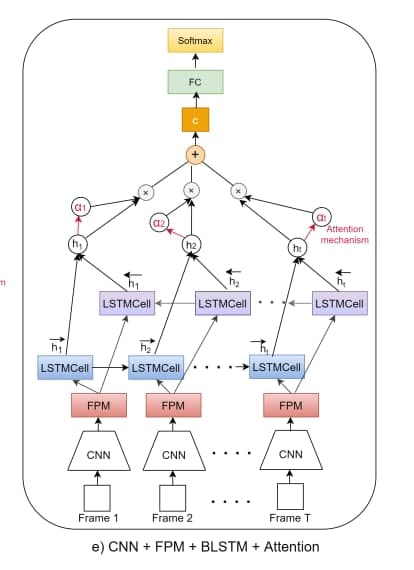


In [5]:
from scipy.stats import truncnorm 
VGG_MEAN = [103.939, 116.779, 123.68]


class cnn_vf(nn.Module):
    def __init__(self):
        super(cnn_vf, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.conv1_0 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=True)
        self.conv1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=True)
        self.vggmiddle = nn.Sequential(*list(vgg.features.children())[2:-5])
        
        for param in self.vggmiddle.parameters():
            param.requires_grad = False
        
        self.vggmiddle.add_module("conv5_2", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.vggmiddle.add_module("relu5_2", nn.ReLU(inplace=True))
        self.vggmiddle.add_module("conv5_3", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.vggmiddle.add_module("relu5_3", nn.ReLU(inplace=True))
        
    def forward(self, rgb, roi):
        '''
        Input shape = (batchsize, seq, 3, h, w)
        '''
#         print("Input rgb: ",rgb.shape)
#         print("Input roi: ",roi.shape)
        red,green,blue = rgb[:,0:1,:,:],rgb[:,1:2,:,:],rgb[:,2:,:,:]
#         print(red.shape,blue.shape,green.shape)
        bgr = torch.cat((blue - VGG_MEAN[0],green - VGG_MEAN[1], red - VGG_MEAN[2]),1)
#         print("BGR: ",bgr.shape)
        features_map = self.conv1_0(bgr)
#         print("features map: ",features_map.shape)
        relevance_map = self.conv1_1(roi)
#         print("relevance_map: ",relevance_map.shape)
        norm_features_map = features_map * relevance_map        
#         print("norm_features_map: ",norm_features_map.shape)
        output = self.vggmiddle(norm_features_map)
        return output
    
        
# model = cnn_vf() 
# summary(model)

In [6]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.pretrained_vgg = models.vgg16(pretrained=True)
        self.pretrained_vgg = nn.Sequential(*list(self.pretrained_vgg.features.children())[:-5])

        # Freeze parameter
        for param in self.pretrained_vgg.parameters():
            param.requires_grad = False

        # Manually add in the layers that are going to be finetuned
        self.pretrained_vgg.add_module("conv5_2", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.pretrained_vgg.add_module("relu5_2", nn.ReLU(inplace=True))
        self.pretrained_vgg.add_module("conv5_3", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.pretrained_vgg.add_module("relu5_3", nn.ReLU(inplace=True))
        
    def forward(self, x):
        '''
        Input shape = (batchsize, seq, 3, h, w)
        '''
        output = self.pretrained_vgg(x)
        return output
        
        
class fpm(nn.Module):
    def __init__(self):
        super(fpm, self).__init__()
        self.pool1_0 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1,dilation=2)
        self.conv1_1 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=1)
        self.conv2_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=1)
        self.conv3_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=2,dilation=2)
        self.conv4_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=4,dilation=4)
        
    def forward(self, x):
        '''
        Input shape = (batchsize, seq, 512, 16, 16)
        '''
        x_1 = self.pool1_0(x)
        x_1 = F.relu(self.conv1_1(x_1))
        x_2 = F.relu(self.conv2_0(x))
        x_3 = F.relu(self.conv3_0(x))
        x_4 = F.relu(self.conv4_0(x))
        
        out = torch.cat([x_1,x_2,x_3,x_4], dim=1)
        
        return out

    
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional = True):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first = True , bidirectional=self.bidirectional)
    
    def forward(self, inputs, hidden):
        output, hidden_state = self.lstm(inputs, hidden)
        return output, hidden_state 
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1 + int(self.bidirectional), batch_size, self.hidden_size), torch.zeros(1 + int(self.bidirectional), batch_size, self.hidden_size))
    
    
class attention(nn.Module):
    def __init__(self):
        super(attention, self).__init__()
        self.dropout_p = 0.25
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.dropout2 = nn.Dropout(self.dropout_p)
        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 1, bias=False)
        
    def forward(self, x):
        hidden = x
        x = torch.tanh(self.linear1(x))
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        x = F.softmax(x, dim=len(x.shape)-1)
        c = torch.sum(x*hidden, dim=1)
        return c
    
    

    
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.bidirectional = True
        self.lstm_hiddensize = 512
        self.dropout_p = 0.25
        
        self.cnn = cnn_vf()
        self.fpm = fpm()
        self.lstm = lstm(512, self.lstm_hiddensize, self.bidirectional)
        self.attn = attention()
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.fc = nn.Linear(1024,226)
        
        
    def forward(self,x,roi):
        embedding_output = []
#         print("x: ",x.shape)
#         print("roi: ",roi.shape)
        for i in range(x.size(1)):
            x_i = self.cnn(x[:,i,:,:,:],roi[:,i,:,:,:])
            x_i = self.fpm(x_i)
            x_i = x_i.mean([-2, -1]) #Global Average Pooling
            embedding_output.append(x_i)
        embedding_output = torch.stack(embedding_output, dim=1)
        
        h_0, h_1 = self.lstm.init_hidden(embedding_output.shape[0])
        h_0 = h_0.to("cuda")
        h_1 = h_1.to("cuda")
        
        output, (final_hidden_state, final_cell_state) = self.lstm(embedding_output, (h_0,h_1)) # final_hidden_state.size() = (1, batch_size, hidden_size) 
        c = self.attn(output)
        output = self.dropout1(self.fc(c))
        output = F.log_softmax(output, dim=len(output.shape)-1)
        
        return output
    
    

In [7]:
model = BaselineModel()
# x = torch.rand((5, 4, 3, 256, 256))
summary(model)

# Define Parameter here:
model_type = "baseline"
model_path = "./model/"
n_epochs = 5
lr = 1e-5
steps = 0 
print_every = 50
validate_every = 50
device = "cuda"

train_loss_ls = []
val_loss_ls = []


time_stamp = str(time.time()).split(".")[0]
current_model_path = model_path + f"{model_type}-{time_stamp}-{n_epochs}e-{batch_size}b/"
os.mkdir(current_model_path)


criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr )
model.to(device)

Layer (type:depth-idx)                   Param #
├─cnn_vf: 1-1                            --
|    └─Conv2d: 2-1                       1,792
|    └─Conv2d: 2-2                       1,792
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-1                  (36,928)
|    |    └─ReLU: 3-2                    --
|    |    └─MaxPool2d: 3-3               --
|    |    └─Conv2d: 3-4                  (73,856)
|    |    └─ReLU: 3-5                    --
|    |    └─Conv2d: 3-6                  (147,584)
|    |    └─ReLU: 3-7                    --
|    |    └─MaxPool2d: 3-8               --
|    |    └─Conv2d: 3-9                  (295,168)
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 (590,080)
|    |    └─ReLU: 3-12                   --
|    |    └─Conv2d: 3-13                 (590,080)
|    |    └─ReLU: 3-14                   --
|    |    └─MaxPool2d: 3-15              --
|    |    └─Conv2d: 3-16                 (1,180,160)
|    |    └─ReLU

BaselineModel(
  (cnn): cnn_vf(
    (conv1_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (vggmiddle): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [8]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
#     confusion_matrix = torch.zeros(num_classes, num_classes)
    with tqdm(testloader, position=0, leave=False) as progress_bar:          
        for images, labels in progress_bar:
    #     for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += criterion(output, labels).item()

            ps = torch.exp(output)
            predictions = ps.max(dim=1)[1]
            equality = (labels.data == predictions)
            accuracy += equality.type(torch.FloatTensor).mean()
    #         for label, prediction in zip(labels.view(-1), predictions.view(-1)):
    #             confusion_matrix[label.long(), prediction.long()] += 1
    return test_loss, accuracy


def test(model, testloader, device='cuda'):  
    model.to(device)
    accuracy = 0

    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
                    
            output = model(images)
            
            ps = torch.exp(output)
            predictions = ps.max(dim=1)[1]
            equality = (labels.data == predictions)
            accuracy += equality.type(torch.FloatTensor).mean()

            for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        
#         recall = metrics.recall(confusion_matrix, num_classes)
#         precision = metrics.precision(confusion_matrix, num_classes)
#         f1 = metrics.f1(confusion_matrix, num_classes)
        print('Testing accuracy: {:.3f}'.format(accuracy/len(testloader)))
        print(f'Testing recall: {recall:.3f}')
        print(f'Testing precision: {precision:.3f}')
        print(f'Testing f1: {f1:.3f}')

    return accuracy, confusion_matrix


def train(model, model_name, batch_size, n_epochs, lr, trainroi_loader, valroi_loader, saved_model_path, device = "cuda"):
#     input_sample, _ =  next(iter(train_loader))
#     print(summary(model, tuple(input_sample.shape[1:]), device=device))
    start_time = datetime.now()

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr= lr)
#     if use_lr_scheduler:
#         scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

    train_loss_ls = []
    val_loss_ls = []

    best_accuracy = 0
    best_recall = 0
    best_accuracy_weights = None
    best_recall_weights = None
    
    steps = 0
    
    running_loss = 0.0
    running_loss2 = 0.0
    
    for e in range(n_epochs):  # loop over the dataset multiple times

        # Training
        model.train()

#         with tqdm(trainroi_loader, position=0, leave=False) as progress_bar:  
#             for images, roi, labels in progress_bar:
        train_it= iter(trainroi_loader)
        for it in tqdm(range(len(trainroi_loader))):
            images,roi,labels = next(train_it)
    
#             print(images.shape)
#             print(roi.shape)
#             print(labels.shape)
            steps += 1
#                 images, labels = images.to(device), labels.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(images,roi)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_loss2 += loss.item()

            if steps % validate_every == -1:

                # Eval mode for predictions
                model.eval()

                # Turn off gradients for validation
                with torch.no_grad():
                    test_loss, accuracy = validation(model, val_loader, criterion, device)
#                         recall = metrics.recall(confusion_matrix, num_classes)
#                         precision = metrics.precision(confusion_matrix, num_classes)
#                         f1 = metrics.f1(confusion_matrix, num_classes)

#                     filepath = saved_model_path + f"{model_name}-{start_time}-b{batch_size}-e{e}.pt"
#                     torch.save(model, filepath)

                running_loss /= validate_every

                time_elapsed = (datetime.now() - start_time)
                tqdm.write(f'===Epoch: {e+1}===')
                tqdm.write(f'== Loss: {running_loss:.3f} Time: {datetime.now()} Elapsed: {time_elapsed}')    
                tqdm.write(f'== Val Loss: {test_loss/len(val_loader):.3f} Val Accuracy: {accuracy/len(val_loader):.3f}') 
#                     tqdm.write(f'== Val Recall: {recall:.3f} Val Precision: {precision:.3f} Val F1: {f1:.3f}')

#         if recall > best_recall:
#             best_recall_weights = model.state_dict()
#             best_recall = recall
#             tqdm.write(f'\n=== BEST RECALL!!! ===')

                if accuracy > best_accuracy:
                    best_accuracy_weights = model.state_dict()
                    best_accuracy = accuracy
                    tqdm.write(f'\n=== BEST ACCURACY!!! ===')

                train_loss_ls.append(running_loss) #/print_every
                val_loss_ls.append(test_loss/len(val_loader))
                running_loss = 0        

                # Make sure training is back on
                model.train()
            elif  steps % print_every == 0:
                print("Epoch: {}/{} - ".format(e+1, n_epochs), "Training Loss: {:.3f} - ".format(running_loss2/print_every))
                running_loss2 = 0
                    
        filepath = saved_model_path + f"{model_name}-{start_time}-b{batch_size}-e{e}.pt"
        torch.save(model, filepath)

    print("Finished training")
    
    plt.plot(train_loss_ls, label = "train_loss")
    plt.plot(val_loss_ls, label = "val_loss")
    plt.legend()
    plt.savefig(saved_model_path+'train_val_loss.png')
    plt.show()
    return model.state_dict(), best_accuracy_weights



In [ ]:
last_weights, best_weights = train(model, "baseline", batch_size, n_epochs, lr, trainroiloader,valroiloader, saved_model_path=current_model_path)

  0%|          | 0/14071 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
  0%|          | 50/14071 [01:35<7:11:27,  1.85s/it]

Epoch: 1/5 -  Training Loss: 12.578 - 


  1%|          | 100/14071 [03:09<7:19:00,  1.89s/it]

Epoch: 1/5 -  Training Loss: 8.317 - 


  1%|          | 150/14071 [04:44<7:33:25,  1.95s/it]

Epoch: 1/5 -  Training Loss: 7.006 - 


  1%|▏         | 200/14071 [06:18<7:16:20,  1.89s/it]

Epoch: 1/5 -  Training Loss: 6.554 - 


  2%|▏         | 250/14071 [07:52<7:12:55,  1.88s/it]

Epoch: 1/5 -  Training Loss: 6.827 - 


  2%|▏         | 260/14071 [08:11<7:11:24,  1.87s/it]

In [ ]:
model.eval()

# Turn off gradients for validation
with torch.no_grad():
    test_loss, accuracy = validation(model, valloader, criterion, device)
#                         recall = metrics.recall(confusion_matrix, num_classes)
#                         precision = metrics.precision(confusion_matrix, num_classes)
#                         f1 = metrics.f1(confusion_matrix, num_classes)

#                     filepath = saved_model_path + f"{model_name}-{start_time}-b{batch_size}-e{e}.pt"
#                     torch.save(model, filepath)

# running_loss /= validate_every

# time_elapsed = (datetime.now() - start_time)
# tqdm.write(f'===Epoch: {e+1}===')
# tqdm.write(f'== Loss: {running_loss:.3f} Time: {datetime.now()} Elapsed: {time_elapsed}')    
# tqdm.write(f'== Val Loss: {test_loss/len(val_loader):.3f} Val Accuracy: {accuracy/len(val_loader):.3f}') 


In [ ]:
print(test_loss/len(valloader), accuracy/len(valloader))

In [ ]:
running_loss = 0.0
for e in range(n_epochs):  # loop over the dataset multiple times
    
    # Training
    model.train()

    for videos, labels in trainloader:
        videos, labels = videos.to(device), labels.to(device)
        steps += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(videos)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if steps % print_every == 0:
            # Eval mode for predictions
#             model.eval()

            # Turn off gradients for validation
#             with torch.no_grad():
#                 test_loss, accuracy = validation(model, val_loader1, criterion, device)

            print("Epoch: {}/{} - ".format(e+1, n_epochs),
                  "Training Loss: {:.3f} - ".format(running_loss/print_every),
#                   "Validation Loss: {:.3f} - ".format(test_loss/len(val_loader1)),
#                   "Validation Accuracy: {:.3f}".format(accuracy/len(val_loader1))
                 )

            train_loss_ls.append(running_loss/print_every)
#             val_loss_ls.append(test_loss/len(val_loader1))
            running_loss = 0
#             filepath = current_model_path + f"b{batch_size}-e{n_epochs}.pt"
#             torch.save(model, filepath)

            # Make sure training is back on
#             model.train()
        
print("Finished training")

In [ ]:
type(aa)

In [ ]:
vgg =  models.vgg16(pretrained=True)
t = nn.Sequential(*list(vgg.features.children())[:-5])

for param in t.parameters():
    param.requires_grad = False

t.add_module("conv5_2", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
t.add_module("relu5_2", nn.ReLU(inplace=True))
t.add_module("conv5_3", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
t.add_module("relu5_3", nn.ReLU(inplace=True))
        
summary(t, (3,256,256))
# i

'''
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
'''

In [ ]:
t.c

In [ ]:
models.vgg16(pretrained=True)